In [6]:
import ray 
import os

def stop_clark_cluster():
    ray.shutdown()
    os.system('ssh ellen /home/john/venv/bin/ray stop')
    os.system('ssh audrey /home/john/venv/bin/ray stop')
    os.system('ssh edna /home/john/venv/bin/ray stop')
    
def start_clark_cluster(clark_cpus = 4, ellen_cpus = 32, audrey_cpus = 32, edna_cpus = 32, 
                        clark_gpus = 0, ellen_gpus = 2, audrey_gpus = 1, edna_gpus = 1):
    stop_clark_cluster()
    config = ray.init(redis_port=6379, redis_password="gn8GWVrMJ3cSX4", num_cpus = clark_cpus, num_gpus = clark_gpus)
    os.system("ssh ellen ray start --address={} --redis-password='gn8GWVrMJ3cSX4' --num-gpus={} --num-cpus={}".format(config['redis_address'], ellen_gpus, ellen_cpus))
    os.system("ssh edna ray start --address={} --redis-password='gn8GWVrMJ3cSX4' --num-gpus={} --num-cpus={}".format(config['redis_address'], edna_gpus, edna_cpus))
    os.system("ssh audrey ray start --address={} --redis-password='gn8GWVrMJ3cSX4' --num-gpus={} --num-cpus={}".format(config['redis_address'], audrey_gpus, audrey_cpus))
    return config

# distributed_computing module example

In [1]:
import pipecaster as pc
cluster = pc.HeadNode(n_cpus=4, n_gpus=0, object_store_memory='auto')
cluster.connect_remote_node('ellen', ray_dir='/home/john/venv/bin/',
                       n_cpus = 32, n_gpus = 2, object_store_memory='auto')
cluster.connect_remote_node('audrey', ray_dir='/home/john/venv/bin/',
                       n_cpus = 32, n_gpus = 1, object_store_memory='auto')
cluster.connect_remote_node('edna', ray_dir='/home/john/venv/bin/',
                       n_cpus = 32, n_gpus = 1, object_store_memory='auto')

2020-12-07 08:51:57,517	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


In [2]:
# wait ~1 second for resources to be update, then you can call
print('resources: {} CPUs and {} GPUS'.format(cluster.count_cpus(), cluster.count_gpus()))

resources: 100.0 CPUs and 4.0 GPUS


In [3]:
cluster.restart()

2020-12-07 08:52:11,617	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


In [5]:
# wait ~1 second for resources to be update, then you can call
print('resources: {} CPUs and {} GPUS'.format(cluster.count_cpus(), cluster.count_gpus()))

resources: 100.0 CPUs and 4.0 GPUS


In [1]:
import pipecaster as pc
import pipecaster.ray_backend as rb

distributor = rb.RayDistributor()
distributor.connect_remote_computer(computer_id='ellen',
                           app_path='/usr/venv/bin/',
                           n_cpus='all', n_gpus=0,
                           object_store_memory='auto')
pc.set_distributor(distributor)

2021-01-15 08:41:32,699	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


In [2]:
distributor.count_cpus()

4

In [3]:
import ray
ray.nodes()

[{'NodeID': '6ac6e7edda67acb882efaa36f4159ea0ade85b43',
  'Alive': True,
  'NodeManagerAddress': '192.168.1.251',
  'NodeManagerHostname': 'mski1413',
  'NodeManagerPort': 54994,
  'ObjectManagerPort': 51692,
  'ObjectStoreSocketName': '/tmp/ray/session_2021-01-15_08-41-32_121132_4105/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2021-01-15_08-41-32_121132_4105/sockets/raylet',
  'MetricsExportPort': 63806,
  'alive': True,
  'Resources': {'object_store_memory': 32.0,
   'node:192.168.1.251': 1.0,
   'CPU': 4.0,
   'memory': 93.0}}]

# from scratch

In [7]:
import ray
import os

config = ray.init()

2020-12-12 09:02:07,252	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


In [8]:
os.system("ssh ellen /home/john/venv/bin/ray start --address={} --num-gpus={} --num-cpus={}".format(config['redis_address'], 2, 32))

0

In [9]:
os.system("ssh audrey /home/john/venv/bin/ray start --address={} --num-gpus={} --num-cpus={}".format(config['redis_address'], 1, 32))

0

In [10]:
os.system("ssh edna /home/john/venv/bin/ray start --address={} --num-gpus={} --num-cpus={}".format(config['redis_address'], 1, 32))

0

# shutdown cluster

In [4]:
import ray
import os
ray.shutdown()
os.system("ssh edna /home/john/venv/bin/ray stop")
os.system("ssh ellen /home/john/venv/bin/ray stop")
os.system("ssh audrey /home/john/venv/bin/ray stop")

256

In [1]:
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification

import pipecaster as pc

X_rand = np.random.rand(500, 30)
X_inf, y = make_classification(n_samples=500, n_features=30, 
                               n_informative=15, class_sep=3, random_state=None)

Xs = [X_rand, X_rand, X_inf, X_rand, X_inf, X_inf]

clf = pc.MultichannelPipeline(n_channels=6)

clf.add_layer(SimpleImputer())
clf.add_layer(StandardScaler())
clf.add_layer(SelectPercentile(percentile=25))
clf.add_layer(5, pc.SelectKBestScores(feature_scorer=f_classif, aggregator=np.mean, k=2)) 
clf.add_layer(5, pc.SelectKBestModels(predictors=KNeighborsClassifier(), k=1), 
              1, LogisticRegression()) 
clf.add_layer(pc.MultichannelPredictor(SVC()))
clf

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,layer_5,out_5
channel,,,,,,,,,,,,
0,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,SelectKBestScores,→,SelectKBestModels,→,MultichannelPredictor,→
1,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,→
2,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,→
3,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,→
4,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,→
5,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,→,→,LogisticRegression,→,▽,→


In [2]:
clf.fit(Xs, y)
clf

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,layer_5,out_5
channel,,,,,,,,,,,,
0,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,SelectKBestScores,,SelectKBestModels,,{MultichannelPredictor}tr,→
1,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,,▽,,▽,
2,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,,▽,
3,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,,▽,,▽,
4,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,
5,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,→,→,{LogisticRegression}cvtr,→,▽,


In [ ]:


    transform_method_name: str or None, default=None
        Set the name of the prediction method used when transform or
        fit_transform are called. If None, the method will be selected
        automatically by the precedence defined in the transform_wrapper
        module.
        
    internal_cv: None, int, or callable, default=5
        Set the internal cv training method for predictors.
        If 1: Internal cv training is inactivated.
        If int > 1: StratifiedKFold(n_splits=internal_cv) for classifiers and
            KFold(n_splits=internal_cv) for regressors.
        If None: The default value of 5 is used.
        If callable: Assumes scikit-learn interface like KFold.
                
    n_processes: int or 'max', default=1
        If 1: Run all split computations in a single process.
        If 'max': Run each split in a different process, using all available
            CPUs
        If int > 1: Run each split in a different process, using up to
            n_processes number of CPUs
            
        """
        Parameters
        ----------
        Xs: list of [ndarray.shape(n_samples, n_features) or None]
            List of feature matrix inputs.
        y: list/array of length n_samples, default=None
            Targets for supervised ML.
        fit_params: dict, defualt=None
            Auxiliary parameters to pass to the fit method of the predictor.
        """

notes:
ray 1.0.1.post1 failed to establish cluster
so I upgraded to 1.1


In [3]:
import ray 
import os

def stop_clark_cluster():
    ray.shutdown()
    os.system('ssh ellen /home/john/venv/bin/ray stop')
    os.system('ssh audrey /home/john/venv/bin/ray stop')
    os.system('ssh edna /home/john/venv/bin/ray stop')
    
def start_clark_cluster(clark_cpus = 4, ellen_cpus = 32, audrey_cpus = 32, edna_cpus = 32, 
                        clark_gpus = 0, ellen_gpus = 2, audrey_gpus = 1, edna_gpus = 1):
    stop_clark_cluster()
    config = ray.init(_redis_password="gn8GWVrMJ3cSX4", num_cpus = clark_cpus, num_gpus = clark_gpus)
    os.system("ssh ellen ray start --address={} --redis-password='gn8GWVrMJ3cSX4' --num-gpus={} --num-cpus={}".format(config['redis_address'], ellen_gpus, ellen_cpus))
    os.system("ssh edna ray start --address={} --redis-password='gn8GWVrMJ3cSX4' --num-gpus={} --num-cpus={}".format(config['redis_address'], edna_gpus, edna_cpus))
    os.system("ssh audrey ray start --address={} --redis-password='gn8GWVrMJ3cSX4' --num-gpus={} --num-cpus={}".format(config['redis_address'], audrey_gpus, audrey_cpus))
    return config

In [25]:
import ray
import os
ray.shutdown()
os.system("ssh edna /home/john/venv/bin/ray stop")
os.system("ssh ellen /home/john/venv/bin/ray stop")
os.system("ssh audrey /home/john/venv/bin/ray stop")

0

In [15]:
import numpy as np
x = np.array([1, 2, None])
x[x == None] = 222
x

array([1, 2, 222], dtype=object)

In [16]:
np.isfinite(None)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [1]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification

import pipecaster as pc

X_rand = np.random.rand(500, 30)
X_inf, y = make_classification(n_samples=500, n_features=30, 
                               n_informative=15, class_sep=3, random_state=None)
Xs = [X_rand, X_rand, X_inf, X_rand, X_inf, X_inf]

clf = pc.MultichannelPipeline(n_channels=6)
clf.add_layer(SimpleImputer())
clf.add_layer(StandardScaler())
clf.add_layer(SelectPercentile(percentile=25))
clf.add_layer(pc.SelectKBestScores(feature_scorer=f_classif, aggregator=np.mean, k=3))
clf.add_layer(pc.SelectKBestModels(predictors=KNeighborsClassifier(), k=2)) 
clf.add_layer(pc.MultichannelPredictor(SVC()))

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,layer_5,out_5
channel,,,,,,,,,,,,
0,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,SelectKBestScores,→,SelectKBestModels,→,MultichannelPredictor,→
1,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,→
2,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,→
3,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,→
4,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,→
5,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,→


In [2]:
clf.fit(Xs, y)

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,layer_5,out_5
channel,,,,,,,,,,,,
0,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,SelectKBestScores,,SelectKBestModels,,{MultichannelPredictor}tr,→
1,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,,▽,,▽,
2,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,,▽,
3,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,,▽,,▽,
4,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,
5,SimpleImputer,→,StandardScaler,→,SelectPercentile,→,▽,→,▽,→,▽,


### Performance analysis

In [61]:
import pipecaster as pc

random_inputs = 7
weak_inputs = 0
strong_inputs = 3
n_input_matrices = random_inputs + weak_inputs + strong_inputs

Xs, y, X_types = pc.make_multi_input_classification(
                        n_informative_Xs=strong_inputs,
                        n_weak_Xs=weak_inputs,
                        n_random_Xs=random_inputs,
                        weak_noise_sd=None,
                        seed=None,
                        n_classes=2, 
                        n_samples=1000, 
                        n_features=100, 
                        n_informative=5, 
                        n_redundant=40, 
                        n_repeated=0, 
                        class_sep=0.70) 

In [62]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf1 = pc.MultichannelPipeline(n_channels=n_input_matrices)
mclf1.add_layer(early_stopping_GBC)
mclf1.add_layer(pc.MultichannelPredictor(SVC()))
mclf1

,layer_0,out_0,layer_1,out_1
channel,,,,
0,GradientBoostingClassifier,→,MultichannelPredictor,→
1,GradientBoostingClassifier,→,▽,→
2,GradientBoostingClassifier,→,▽,→
3,GradientBoostingClassifier,→,▽,→
4,GradientBoostingClassifier,→,▽,→
5,GradientBoostingClassifier,→,▽,→
6,GradientBoostingClassifier,→,▽,→
7,GradientBoostingClassifier,→,▽,→
8,GradientBoostingClassifier,→,▽,→


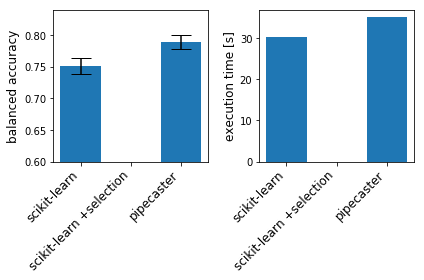

In [63]:
%matplotlib inline
import time
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from scipy.stats import sem

n_cpus = pc.count_cpus()

t = time.time()
pc_accuracies = pc.cross_val_score(mclf1, Xs, y, scorer=balanced_accuracy_score, cv=8, n_processes=n_cpus)
pc_time = time.time() - t

X = np.concatenate(Xs, axis=1)
clf = Pipeline([('scaler', StandardScaler()), 
                ('selector', SelectPercentile(score_func=f_classif, percentile=2)),
                ('GradientBoostingClassifier', early_stopping_GBC)])
t = time.time()
# sk_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=10, n_jobs=n_cpus)
sk_accuracies = [0, 0, 0]
sk_time = time.time() - t

clf = Pipeline([('GradientBoostingClassifier', early_stopping_GBC)])
t = time.time()
sk_ns_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=8, n_jobs=n_cpus)
sk_ns_time = time.time() - t

fig, axes = plt.subplots(1, 2)
xlabels = ['scikit-learn', 'scikit-learn +selection', 'pipecaster']
axes[0].bar(xlabels, [np.mean(sk_ns_accuracies), np.mean(sk_accuracies), np.mean(pc_accuracies)], 
        yerr=[sem(sk_ns_accuracies), sem(sk_accuracies), sem(pc_accuracies)], capsize=10)
axes[0].set_ylim(.60)
axes[0].set_ylabel('balanced accuracy', fontsize=12)
axes[0].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
axes[1].bar(xlabels, [np.mean(sk_ns_time), np.mean(sk_time), np.mean(pc_time)])
axes[1].set_ylabel('execution time [s]', fontsize=12)
axes[1].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()
# plt.savefig('performance_comparison.svg')

In [25]:
class Foobar:
    def __init__(self):
        self.x = 222
        
    def set_x(self, x):
        self.x = x
        return self

In [26]:
fb = Foobar().set_x(123)

In [27]:
fb.x

123